<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/Binario_FL_inception_v4_BalanceoImblearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [1]:
!pip install fastai==2.6.3 -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.9 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [2]:
!pip install wwf -q

In [3]:
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-19 09:18:54 URL:https://uca7420269d6bfa5810464b85f21.dl.dropboxusercontent.com/cd/0/inline2/Bnel6ytI6CJ3PVvZjXq8PEpK2hMijCGSxjeyHFLcp3_54eCah0AucdcMOz4b1sgZRCey03ZS0nZRe8vb3qn1Am-JtUJCq2YDWTFvsxivNnpaFF-Qro4lSniWdTYJbsoUpQPT5u1HLkSJ5jJWTHXeY08ngKweOOeiJqw95vKqwM5ouQMbRCTl_rM_rxxukkeHN60B9MvPly_62uqOnpyrT98P96a6LBq-B_7_83ru2zbWUzK2zkWxP5yhrYUUkf1gG-q6NhQhLHGfASqOOxu6ZrVI7s4CYGiFNLjnFrAGFXW4yMsIXMPMbALxRqRUKjaDnfXgbZZKFO7BHXulYUEP7APCUt01W03AVzLbxozIiyIbcg6DnbKDq5BrTNvL3WtkAt1c5cXUvpQ9yjB2OMbNIgH_apWS2WVdvqGfsMm_Pq_NOg/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 09:18:57 URL:https://uce03579aafca5bd97d93d919225.dl.dropboxusercontent.com/cd/0/inline2/BneLz_RcBeVMkSYMTVBV4YH8rLUS_gsprp9SECDq5IG_KzFJXZ0Lsnx_JAe95B90jPUjGRURV2HsvBqbvy1P63Vdfy4f1_pQhfZEFXDVQoEgxAjnvKXQIPAclQ5IFLnR6vhODos6cHhUcDXg83VR8oGmPn0DgQ-rW4rZSrIzM7sYehe-mCqJhzw7W5jqA3DK8WxWkmP5EieTuPkGRzN6Tt6X6lA2gfYvMceJprNhuEzRdZ3jDzqlRq5oOgQru9OrEM1GhChIWvu6ngkquq-cyetqKg428fzq3cx11Xb_eLfe_x85t4cI3zdXDCsYpNrC_DR

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [13]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [14]:
path = Path('dataset')

## Balanceo

In [15]:
y = df_train.Disease_Risk
X = df_train.drop('Disease_Risk', axis=1)

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.50) #Aumentaremos hasta la mitad de lo que es la clase mayoritaria (759)
under = RandomUnderSampler(sampling_strategy=1) #clase mayoriataria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [17]:
from collections import Counter

# evaluate pipeline
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 759, 1: 759})


In [18]:
X['Disease_Risk'] = y
df_train = X

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [19]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [20]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [21]:
dls = db.dataloaders(path,bs=128)

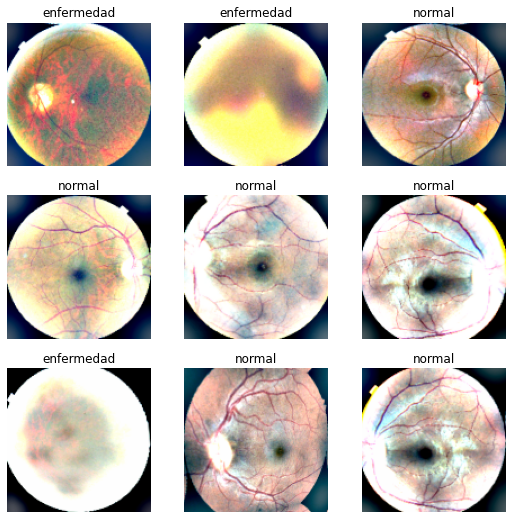

In [22]:
dls.show_batch()

In [23]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [52]:
metrics = [ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = timm_learner(dls, 'inception_v4', metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


SuggestedLRs(minimum=0.004786301031708717, steep=9.12010818865383e-07, valley=0.0008317637839354575, slide=0.0063095735386013985)

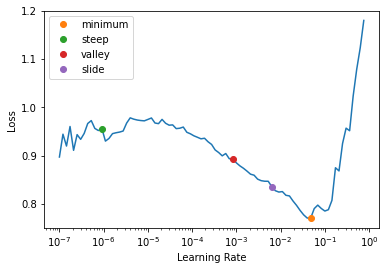

In [53]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.033763,0.439346,0.510938,0.198653,0.440299,0.273782,0.489062,00:11


Better model found at epoch 0 with valid_loss value: 0.4393460154533386.


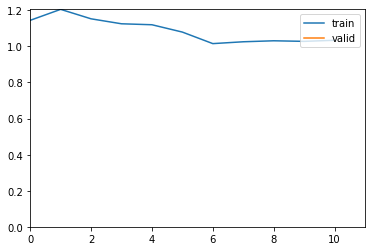

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,0.965303,0.448511,0.443750,0.196721,0.537313,0.288000,0.556250,00:10
1,0.976599,0.464094,0.475000,0.204678,0.522388,0.294118,0.525000,00:09
2,0.952809,0.444012,0.493750,0.204969,0.492537,0.289474,0.506250,00:09
3,0.953709,0.490182,0.476562,0.210375,0.544776,0.303534,0.523438,00:09
4,0.958968,0.463954,0.520312,0.218241,0.500000,0.303855,0.479688,00:09
5,0.945421,0.469736,0.518750,0.222930,0.522388,0.312500,0.481250,00:10
6,0.942872,0.477034,0.506250,0.219136,0.529851,0.310044,0.493750,00:09
7,0.939437,0.462879,0.523438,0.221498,0.507463,0.308390,0.476562,00:09
8,0.943334,0.432758,0.520312,0.212625,0.477612,0.294253,0.479688,00:09
9,0.939933,0.426002,0.564062,0.232472,0.470149,0.311111,0.435937,00:09


Better model found at epoch 0 with valid_loss value: 0.4485110640525818.


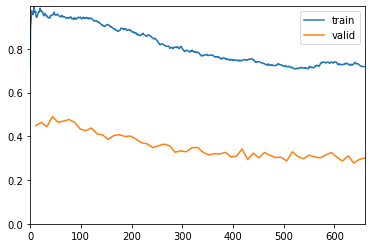

Better model found at epoch 2 with valid_loss value: 0.44401177763938904.
Better model found at epoch 8 with valid_loss value: 0.43275848031044006.
Better model found at epoch 9 with valid_loss value: 0.42600217461586.
Better model found at epoch 11 with valid_loss value: 0.4109368324279785.
Better model found at epoch 12 with valid_loss value: 0.40647897124290466.
Better model found at epoch 13 with valid_loss value: 0.3861249089241028.
Better model found at epoch 19 with valid_loss value: 0.3704320788383484.
Better model found at epoch 20 with valid_loss value: 0.36544153094291687.
Better model found at epoch 21 with valid_loss value: 0.34830886125564575.
Better model found at epoch 25 with valid_loss value: 0.32705944776535034.
Better model found at epoch 31 with valid_loss value: 0.3146728277206421.
Better model found at epoch 35 with valid_loss value: 0.30630621314048767.
Better model found at epoch 38 with valid_loss value: 0.29374703764915466.
Better model found at epoch 45 with

In [54]:
%%time
learn.fine_tune(60,base_lr=1e-5)

## Evaluando el Modelo

In [55]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [56]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.82.

In [57]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6968749761581421.


(#6) [nan,0.6968749761581421,0.25806451612903225,0.23880597014925373,0.24806201550387597,0.3031249940395355]

Exportamos el modelo:

In [58]:
learn.to_fp32()
learn.export('Binario_FL_inception_v4_BalanceoImblearn.pkl')

## Interpretación del modelo

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


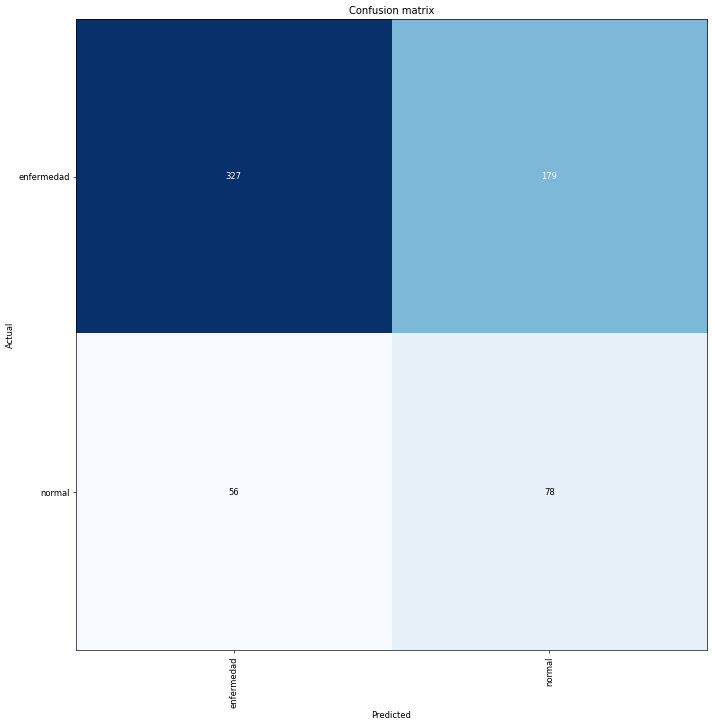

In [59]:
learn_inf = load_learner('Binario_FL_inception_v4_BalanceoImblearn.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)